In [1]:
!pip install imutils -q

# Imports

In [2]:
import os
import cv2
import joblib
import pickle
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
from skimage import exposure
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from imutils.object_detection import non_max_suppression
import imgaug.augmenters as iaa
import warnings
warnings.filterwarnings("ignore")

# Constant

In [3]:
# Directories containing positive and negative samples
positive_dir = '/kaggle/input/coffee-packets/p'
negative_dir = '/kaggle/input/coffee-packets/n'

# Test video path
video_path = '/kaggle/input/coffee-packets/video1.mp4'

# Util

In [4]:
# Function to extract HoG features from an image
def extract_hog_features(image):
    resized_image = cv2.resize(image, (128, 64))  # Standard size for HoG
    hog_features, hog_image = hog(resized_image, 
                                  orientations=18,
                                  pixels_per_cell=(8, 8),
                                  cells_per_block=(2, 2), 
                                  visualize=True, 
                                  block_norm='L2-Hys')
    return hog_features, hog_image

def extract_hog_features_over_img(image):
    resized_image = cv2.resize(image, (128, 64))  # Standard size for HoG
    hog_features, hog_image = hog(resized_image, 
                                  orientations=18,
                                  pixels_per_cell=(8, 8),
                                  cells_per_block=(2, 2), 
                                  visualize=True, 
                                  block_norm='L2-Hys')  # Removed multichannel
    return hog_features

def augment_image(image, num_augmentations=5):
    seq = iaa.Sequential([
        iaa.Fliplr(0.5),  # horizontal flip
        iaa.Affine(rotate=(-20, 20)),  # rotate
        iaa.Multiply((0.8, 1.2))  # change brightness
    ])
    return [seq(image=image) for _ in range(num_augmentations)]

In [7]:
def get_video_frames():
    # Open the video file
    video_capture = cv2.VideoCapture(video_path)

    # Check if video file opened successfully
    if not video_capture.isOpened():
        raise IOError("Error: Could not open video file.")

    # Store video frames in a list
    frames = []

    while True:
        # Capture frame-by-frame
        ret, frame = video_capture.read()

        # If the frame was not retrieved properly, break the loop
        if not ret:
            break

        # Append frame to the list
        frames.append(frame)

    # Release the video capture object
    video_capture.release()
    
    # Return the frames
    return frames

# Function to perform detection on a single image
def detect_objects_in_image(image, model, window_size=(80, 80), step_size=20):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    rects = []
    
    for y in range(0, gray.shape[0] - window_size[1], step_size):
        for x in range(0, gray.shape[1] - window_size[0], step_size):
            window = gray[y:y + window_size[1], x:x + window_size[0]]
            features = extract_hog_features_over_img(window).reshape(1, -1)
            prediction = model.predict(features)

            if prediction == 1:
                rects.append((x, y, x + window_size[0], y + window_size[1]))
    
    # Apply non-maximum suppression to the rectangles
    rects = np.array(rects)
    pick = non_max_suppression(rects, probs=None, overlapThresh=0.1)
    
    for (xA, yA, xB, yB) in pick:
        cv2.rectangle(image, (xA, yA), (xB, yB), (0, 255, 0), 2)
    
    return image

# Step1: Extract features from the dataset using HoG

In [23]:
# Load and extract HoG features from the dataset
features = []
labels = []

for filename in os.listdir(positive_dir):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image = cv2.imread(os.path.join(positive_dir, filename), cv2.IMREAD_GRAYSCALE)
        hog_feat, _ = extract_hog_features(image)
        features.append(hog_feat)
        labels.append(1)  # Positive samples labeled as 1
        
        # Augment and add the augmented images
        for augmented_image in augment_image(image):
            hog_feat, hog_img = extract_hog_features(image)
            features.append(hog_feat)
            labels.append(1)

for filename in os.listdir(negative_dir):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image = cv2.imread(os.path.join(negative_dir, filename), cv2.IMREAD_GRAYSCALE)
        hog_feat, _ = extract_hog_features(image)
        features.append(hog_feat)
        labels.append(0)  # Negative samples labeled as 0
        
#         # Augment and add the augmented images
#         for augmented_image in augment_image(image)[:2]:
#             hog_feat, hog_img = extract_hog_features(image)
#             features.append(hog_feat)
#             labels.append(0)


# Step2: Set Feature and Predictor

In [24]:
# Convert lists to NumPy arrays
features = np.array(features)
labels = np.array(labels)

# Step3: Split the dataset

In [25]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Step4: Fit the model using Linear SVM Classifier

In [26]:
# Train a linear SVM classifier with cross-validation
clf = LinearSVC()
cv_scores = cross_val_score(clf, X_train, y_train, cv=5)

# print("Cross-Validation Scores:", cv_scores)
# print("Mean CV Score:", np.mean(cv_scores))

clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

In [27]:
# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       1.00      1.00      1.00       115

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160



In [28]:
# Save the model to a file
with open('hog_svm_model.pkl', 'wb') as file:
    joblib.dump(clf, file)

# Step5: Load the model for detection

In [29]:
# Load the trained model
clf = joblib.load('hog_svm_model.pkl')

In [30]:
frames = get_video_frames()

# Step6: Make Detection

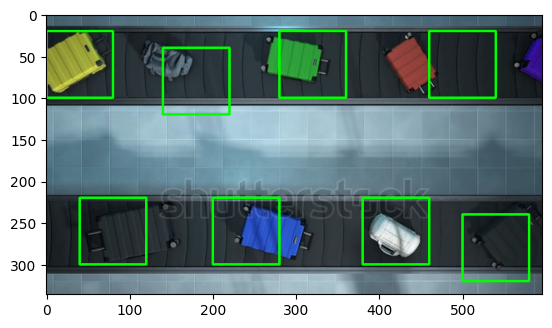

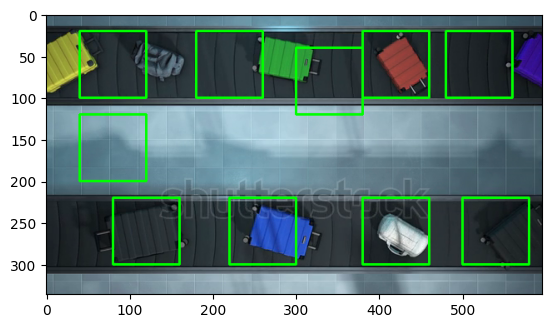

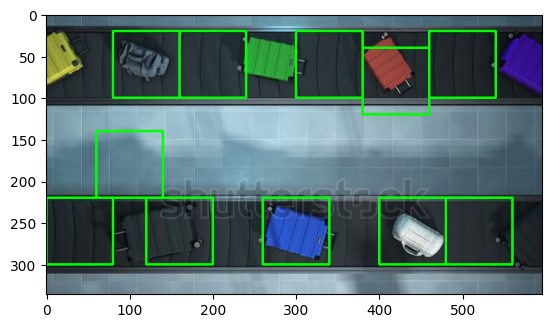

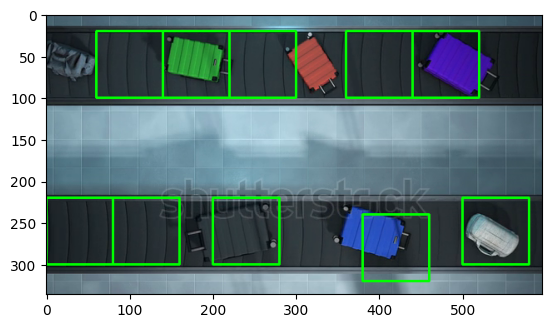

In [31]:
random_range = [14, 18, 25, 60]

for idx in random_range:
    final_image = detect_objects_in_image(frames[idx].copy(), clf)
    plt.imshow(final_image)
    plt.show()

## Conclusion Points

1. **Detection Accuracy**:
   - **Haar Features**: Achieved higher detection accuracy in identifying luggage bags on the conveyor belt.
   - **HOG Features**: Showed lower detection accuracy compared to Haar features.

2. **Performance in Varied Lighting Conditions**:
   - **Haar Features**: Performed robustly under varied lighting conditions typically found in airport environments.
   - **HOG Features**: Less effective under inconsistent lighting, leading to reduced detection performance.

3. **Speed and Efficiency**:
   - **Haar Features**: Typically faster in detection due to the efficient cascade classifier, making it suitable for real-time applications.
   - **HOG Features**: Computationally more intensive, resulting in slower detection times.

4. **Complexity and Training Time**:
   - **Haar Features**: Training can be more complex and time-consuming due to the need for extensive positive and negative samples.
   - **HOG Features**: Generally easier and faster to train but may require additional post-processing to improve detection accuracy.

5. **Adaptability to Object Variability**:
   - **Haar Features**: Better at capturing the essential features of luggage bags, leading to improved detection even with variability in bag shapes and sizes.
   - **HOG Features**: Struggled with the variability, affecting detection consistency.


## Logical Reasoning

1. **Feature Representation**:
   - **Haar Features**: Capture edge and line features efficiently, which are prominent in the structured shapes of luggage bags. The cascade classifier combines these features effectively to distinguish between bags and non-bag objects.
   - **HOG Features**: Rely on gradient orientation histograms that work well for textured patterns. However, luggage bags often lack distinct texture, making HOG less effective for this application.

2. **Environmental Adaptability**:
   - **Haar Features**: Are less sensitive to changes in lighting and background, providing consistent performance in the dynamic environment of airport conveyor belts.
   - **HOG Features**: Tend to be affected by lighting variations, leading to false negatives or positives under different lighting conditions.

3. **Real-time Detection Requirements**:
   - **Haar Features**: The cascading nature allows for rapid decision-making, crucial for real-time monitoring systems like airport security.
   - **HOG Features**: The processing time for HOG features is higher, making it less suitable for real-time applications where quick responses are necessary.

In conclusion, for the use case of luggage bag detection on an airport conveyor belt, Haar feature cascades outperform HOG features due to their robustness to environmental changes, speed, and higher accuracy in detecting the structured shapes of luggage bags.
